In [84]:
import pandas as pd
import numpy as np

1. Import confirmed, recovered and deaths data set for a given country

In [366]:
confirmed = pd.read_csv('DATA/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
recovered = pd.read_csv('DATA/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')
deaths = pd.read_csv('DATA/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')

2. Pre-process the datasets

In [367]:
def reformat(df, country, col_name):
    
    df = df[df['Country/Region'] == country]
    index = df.iloc[0].name

    df = df.T
    df = df.rename({index: col_name}, axis = 1)
    # get rid of columns that do not represent the number of recovered/confirmed/deaths 
    df = df.iloc[4:,:]
    
    return df

    #df = df[df[col_name] > 0]


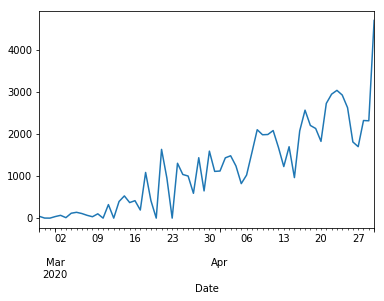

In [500]:
dataframe_new['Recovered Daily'].plot()

In [368]:
recovered = reformat(recovered, 'Italy', 'Recovered cases')
confirmed = reformat(confirmed, 'Italy', 'Confirmed cases')
deaths = reformat(deaths, 'Italy', 'Deaths cases')

recovered.tail()

,Recovered cases
4/26/20,64928
4/27/20,66624
4/28/20,68941
4/29/20,71252
4/30/20,75945


3. Create new data frame recovered per day so we know how many people recovered from the epidemic on a given day


**problem** : Here, I see that recovered_daily contains a negative value, therefore recovered is not fully incremental. ??? Change dataset?

In [369]:
recovered_daily = recovered.diff()
recovered_daily.iloc[0,:] = 0

In [370]:
deaths_daily = deaths.diff()
deaths_daily.iloc[0] = 0

4. Generate dataset infected representing the number of infected individuals at a given time t (not the new number of infected, number of actively infected individuals)

$$\text{confirmed}(t)=\text{confirmed}(t)-\sum_{i=\text{day}_0}^{t}\text{recovered_daily(i)}-\sum_{i=\text{day}_0}^{t}\text{deaths_daily}(i)$$

In [371]:
infected_ = []
days_ = []
# i: date (time t)
# row: row
acc_deaths = 0
acc_recovered = 0

for i, row in confirmed.iterrows():
    acc_recovered += recovered_daily.loc[i]['Recovered cases']
    acc_deaths += deaths_daily.loc[i]['Deaths cases']
    
    diff = row['Confirmed cases'] - acc_recovered - acc_deaths
    
    infected_.append(diff)
    days_.append(i)

Careful, infected represents active number of infected, not new number of infected

In [372]:
infected = pd.DataFrame({'Date': days_,'Infected Cases': infected_})

In [373]:
recovered = recovered.reset_index().rename({'index':'Date'}, axis = 1)

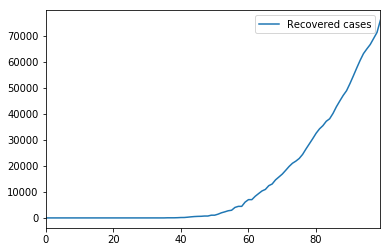

In [374]:
recovered.plot()

Now we can start working on predicting our gammas. 
Recovered is cumulative, as expected (absorbing state in our SIR model) and infected represents the number of infected individual at a certain date

In [375]:
data = recovered.merge(infected, on='Date')

In [376]:
data['Date'] = pd.to_datetime(data['Date'])
#df['DOB'] = pd.to_datetime(df.DOB)


In [377]:
data = data.set_index('Date')
data['Recovered Daily'] = recovered_daily
data.head()

,Recovered cases,Infected Cases,Recovered Daily
Date,,,
2020-01-22,0,0,0
2020-01-23,0,0,0
2020-01-24,0,0,0
2020-01-25,0,0,0
2020-01-26,0,0,0


In [378]:
data = data.reset_index()
data.tail()

,Date,Recovered cases,Infected Cases,Recovered Daily
95,2020-04-26,64928,106103,1808
96,2020-04-27,66624,105813,1696
97,2020-04-28,68941,105205,2317
98,2020-04-29,71252,104657,2311
99,2020-04-30,75945,101551,4693


In [379]:
dataframe = pd.concat([data['Date'],data['Recovered Daily'], data['Infected Cases'].shift(7),
                   data['Infected Cases'].shift(8),data['Infected Cases'].shift(9),
                   data['Infected Cases'].shift(10),data['Infected Cases'].shift(11),
                   data['Infected Cases'].shift(12),data['Infected Cases'].shift(13),
                   data['Infected Cases'].shift(14),data['Infected Cases'].shift(15),
                   data['Infected Cases'].shift(16),data['Infected Cases'].shift(17),
                   data['Infected Cases'].shift(18),data['Infected Cases'].shift(19),
                   data['Infected Cases'].shift(20),data['Infected Cases'].shift(21)], axis=1)

To go on I think it would be better to have a larger data set

In [380]:
# create lagged dataset
dataframe.columns = ['Date', 'Recovered Daily', 'Infected cases t-7','Infected cases t-8','Infected cases t-9',
                    'Infected cases t-10','Infected cases t-11','Infected cases t-12','Infected cases t-13',
                    'Infected cases t-14','Infected cases t-15','Infected cases t-16','Infected cases t-17',
                    'Infected cases t-18','Infected cases t-19','Infected cases t-20','Infected cases t-21']

# Keep data such that we have value t-21 at any given day t
dataframe = dataframe[~np.isnan(dataframe['Infected cases t-21'])]



In [381]:
dataframe = dataframe.set_index('Date')

#  Linear regression model

In [382]:
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt  
import seaborn as seabornInstance 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
%matplotlib inline

If we take out the first 15 days due to noise, unstability of covid-19 progress

In [383]:
dataframe_new = dataframe.iloc[15:,:].copy()

In [384]:
y = dataframe_new['Recovered Daily'].values
X = dataframe_new.iloc[:,1:].values

In [385]:
dataframe.loc[:,'Recovered Daily'] = dataframe_new.loc[:,'Recovered Daily'].apply(pd.to_numeric)


In [386]:
dataframe_new['Recovered Daily'] = dataframe_new['Recovered Daily'].apply(pd.to_numeric)


/usr/local/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


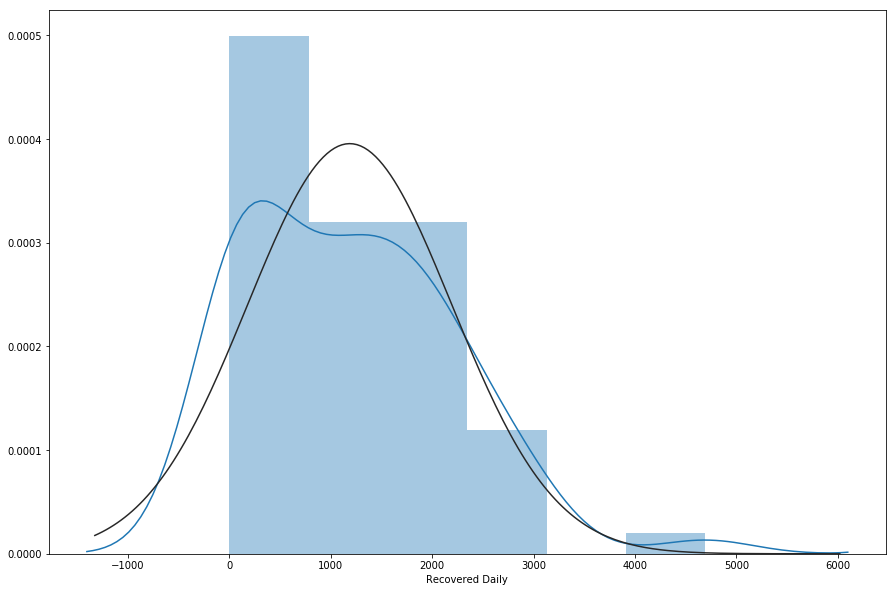

In [387]:
from scipy.stats import norm

plt.figure(figsize=(15,10))
plt.tight_layout()
seabornInstance.distplot(dataframe_new['Recovered Daily'], fit=norm)

In [388]:
# split into train and test sets

pct_90 = int(np.ceil(90*len(X)/100))

#predict las 10%

train, test = dataframe_new.values[:pct_90], dataframe_new.values[pct_90:]
y_train, X_train = train[:,0], train[:,1:]
y_test, X_test = test[:,0], test[:,1:]

In [389]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [390]:
regressor = LinearRegression(normalize=True)  
regressor.fit(X_train, y_train) #training the algorithm

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [391]:
y_pred = regressor.predict(X_test)


In [392]:
df = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})
df

,Actual,Predicted
0,2622.0,2672.016637
1,1808.0,2814.129695
2,1696.0,2740.522898
3,2317.0,2663.110074
4,2311.0,2582.526779
5,4693.0,2718.994092


In [393]:
print('Mean Absolute Error:',  "%.2f" % (metrics.mean_absolute_error(y_test, y_pred),))  
print('Mean Squared Error:', "%.2f" % (metrics.mean_squared_error(y_test, y_pred),) )  
print('Root Mean Squared Error:', "%.2f" % (np.sqrt(metrics.mean_squared_error(y_test, y_pred),)))

Mean Absolute Error: 782.05
Mean Squared Error: 1032674.17
Root Mean Squared Error: 1016.21


In [394]:
regressor.coef_

array([ 0.01604569,  0.1920734 , -0.3519096 ,  0.07565021,  0.26863294,
       -0.13826393,  0.05843547, -0.24893897,  0.15295211, -0.01176082,
       -0.05234905, -0.10613012,  0.17095807,  0.01623989, -0.01370672])

In [395]:
print("R^2 Score: ","%.3f" % (regressor.score(X_test, y_test),) )

R^2 Score:  -0.035


In [396]:
coeff_df = pd.DataFrame(regressor.coef_, dataframe.iloc[:,1:].columns, columns=['Coefficient'])  
coeff_df

,Coefficient
Infected cases t-7,0.016046
Infected cases t-8,0.192073
Infected cases t-9,-0.351910
Infected cases t-10,0.075650
Infected cases t-11,0.268633
Infected cases t-12,-0.138264
Infected cases t-13,0.058435
Infected cases t-14,-0.248939
Infected cases t-15,0.152952
Infected cases t-16,-0.011761


### Plot coefficients (distribution of gamma)

/usr/local/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


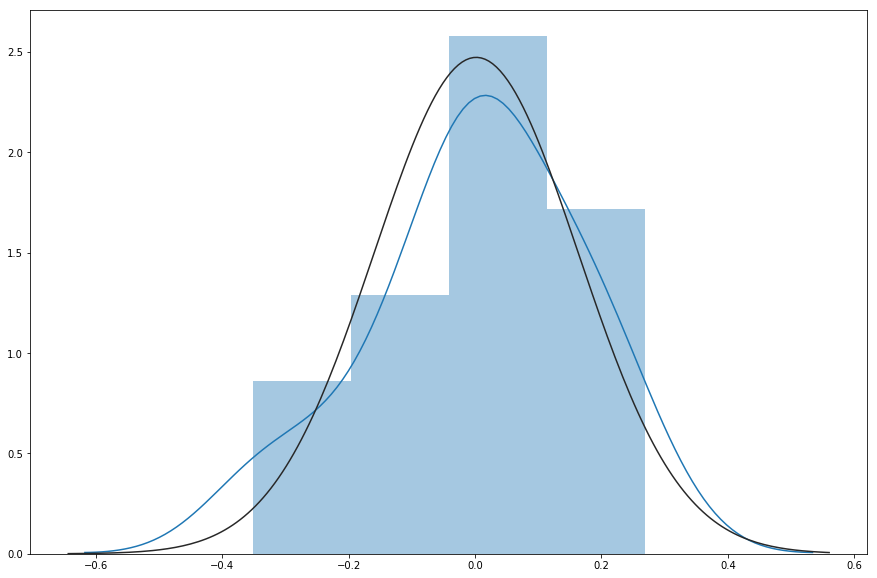

In [397]:
plt.figure(figsize=(15,10))
plt.tight_layout()
seabornInstance.distplot(coeff_df, fit=norm)

**Update this**

For a unit increase in the number of recovered individuals at time t, that means there is:
- An increase of 21 infected at day t-20
- A decrease of 13 infected at day t-18

We see that the closer we are to the recovery date, the lower the number of infected cases has an impact on the number od recovered cases 

### Plot Actual values (y test) versus predicted values

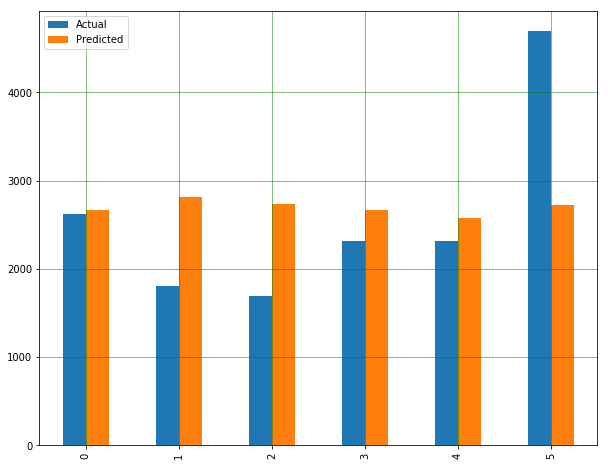

In [398]:
df.plot(kind='bar',figsize=(10,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

There are many factors that may have contributed to this inaccuracy, for example :

- **Need more data**: We need to have a huge amount of data to get the best possible prediction.
- **Bad assumptions**: We made the assumption that this data has a linear relationship, but that might not be the case. Visualizing the data may help us determine that.
- **Poor features**: The features we used may not have had a high enough correlation to the values we were trying to predict.

#  ridge regression (L2)

In [399]:
from sklearn.linear_model import Ridge
from sklearn import linear_model
import numpy as np
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

rng = np.random.RandomState(0)


In [400]:
#y = dataframe_new['Recovered cases'].values
#X = dataframe_new.iloc[:,1:].values

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# split into train and test sets

pct_90 = int(np.ceil(90*len(X)/100))

#predict las 10%

train, test = dataframe_new.values[:pct_90], dataframe_new.values[pct_90:]
y_train, X_train = train[:,0], train[:,1:]
y_test, X_test = test[:,0], test[:,1:]

In [401]:
# Create ridge regression with three possible alpha values

clf = Ridge(alpha=1, normalize=True)
# Fit the linear regression
model = clf.fit(X_train, y_train)

#y_pred = clf.predict(X_test)
y_pred = clf.predict(X_test)

In [402]:
clf.score(X_test, y_test)

0.03512744043047278

In [403]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 713.1160049887295
Mean Squared Error: 962512.0792585871
Root Mean Squared Error: 981.0769996583281


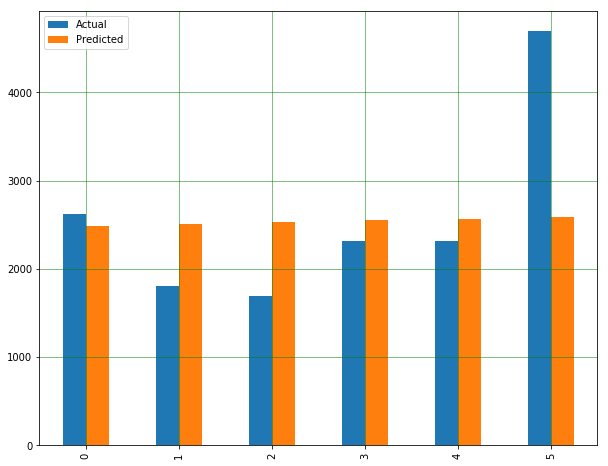

In [404]:
df = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})
df.plot(kind='bar',figsize=(10,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

#  Lasso Regression (L1)

In [405]:
#y = dataframe_new['Recovered cases'].values
#X = dataframe_new.iloc[:,1:].values

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# split into train and test sets

pct_90 = int(np.ceil(90*len(X)/100))

#predict las 10%

train, test = dataframe_new.values[:pct_90], dataframe_new.values[pct_90:]
y_train, X_train = train[:,0], train[:,1:]
y_test, X_test = test[:,0], test[:,1:]


clf = linear_model.Lasso(alpha=0.1)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


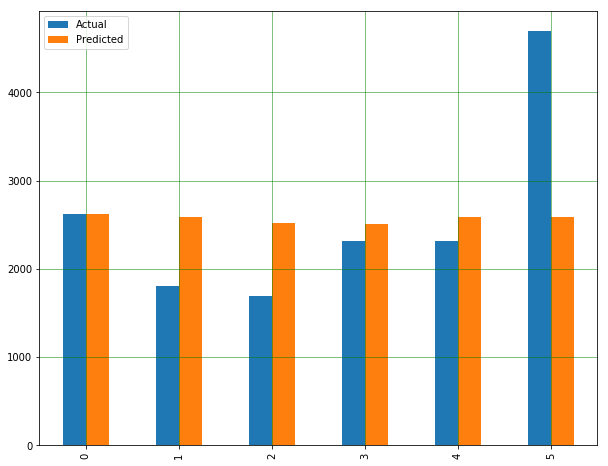

In [406]:
df = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})
df.plot(kind='bar',figsize=(10,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()


In [407]:
clf.score(X_test, y_test)

0.029224502425862938

# Linear Elastic Net regression 
(Linear regression with combined L1 and L2 priors as regularizer)

The elastic net method overcomes the limitations of the LASSO (least absolute shrinkage and selection operator) method which uses a penalty function based on

$$||\beta||_1=\sum_{j=1}^p{|\beta_j|}$$

The parameters for the elastic net method are defined by

$$\hat{\beta}\equiv \text{argmin}_{\beta}(||y-X\beta||^2+\lambda_2||\beta||^2+\lambda_1||\beta||_1)$$

In our case here, $\lambda_1=\lambda_2=\alpha$

In [408]:
y = dataframe_new['Recovered Daily'].values
X = dataframe_new.iloc[:,1:].values

#-----#

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# split into train and test sets

pct_90 = int(np.ceil(90*len(X)/100))

#predict las 10%

X_train, X_test = X[:pct_90], X[pct_90:]
y_train, y_test =y[:pct_90], y[pct_90:]


#-----#

clf = linear_model.ElasticNet(alpha=0.1)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [409]:
import scipy

In [410]:
df = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})
df


,Actual,Predicted
0,2622,2624.267050
1,1808,2583.879545
2,1696,2520.669794
3,2317,2509.132289
4,2311,2584.171594
5,4693,2591.383702


In [411]:
clf.score(X_test, y_test)

0.02922456606550516

In [412]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 694.9560948510211
Mean Squared Error: 968400.5127333269
Root Mean Squared Error: 984.0734285272247


In [413]:
coeff_df = pd.DataFrame(regressor.coef_, dataframe.iloc[:,1:].columns, columns=['Coefficient'])  
coeff_df

,Coefficient
Infected cases t-7,0.016046
Infected cases t-8,0.192073
Infected cases t-9,-0.351910
Infected cases t-10,0.075650
Infected cases t-11,0.268633
Infected cases t-12,-0.138264
Infected cases t-13,0.058435
Infected cases t-14,-0.248939
Infected cases t-15,0.152952
Infected cases t-16,-0.011761


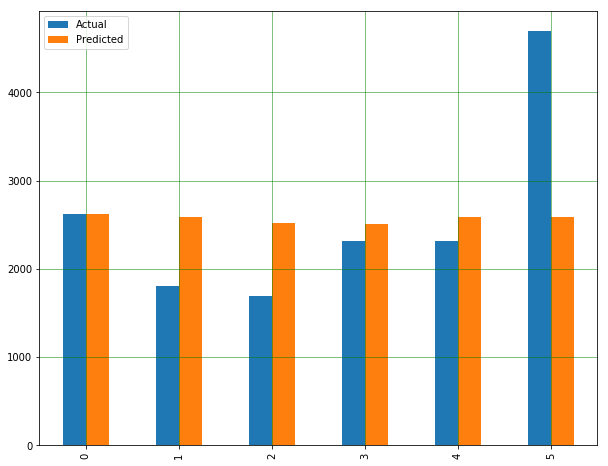

In [415]:
df.plot(kind='bar',figsize=(10,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

## Laplacian

In [416]:
y = dataframe_new['Recovered Daily'].values
X = dataframe_new.iloc[:,1:].values

#-----#

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# split into train and test sets

pct_90 = int(np.ceil(90*len(X)/100))

#predict las 10%

X_train, X_test = X[:pct_90], X[pct_90:]
y_train, y_test =y[:pct_90], y[pct_90:]



In [417]:
X_train.shape

(58, 15)

### Laplacian Regression using optimize.minimize

In [418]:
import sys

#X aas args, aergs only values we are looking forward optimizing

N = 15
pct_90 = int(np.ceil(90*len(X)/100))


X_train, X_test = X[:pct_90], X[pct_90:]
y_train, y_test =y[:pct_90], y[pct_90:]

def func(x):
    
    gamma = np.array(x[:N])
    
    M_values = x[N:]
    
    M = M_values.reshape(N,N)
        
    X = X_train @ M
    
    # If we decide to apply the basic ridge loss, that is minimize |y - XMG|^2 +0.1*|G|**2
    
    to_min = np.linalg.norm(y_train - X_train @ M @ gamma)**2 + 0.1 * np.linalg.norm(gamma)**2
    #pred_train_rr= rr.predict(X_train)
    
    # If we decide to minimize the sum of gamma squared
    
    to_min2 = np.sum(gamma**2)
    
    fail = sys.maxsize * 2 + 1
    
    if np.sum(gamma>0) == len(gamma):
        return to_min2
    else:
        return fail

length = N + N**2

In [419]:
lap_slsqp = scipy.optimize.minimize(func,np.random.rand(1, length), method='SLSQP')

gamma = lap_slsqp['x'][:N]
M = lap_slsqp['x'][N:].reshape(N,N)

In [420]:

clf = linear_model.Ridge(alpha=1.0)

clf.fit(X_train @ M, y_train)

#clf.coef_ = gamma

y_pred = clf.predict(X_test @ M)

In [421]:
df = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})
df


,Actual,Predicted
0,2622,2672.025033
1,1808,2814.139059
2,1696,2740.527144
3,2317,2663.116962
4,2311,2582.537503
5,4693,2718.993663


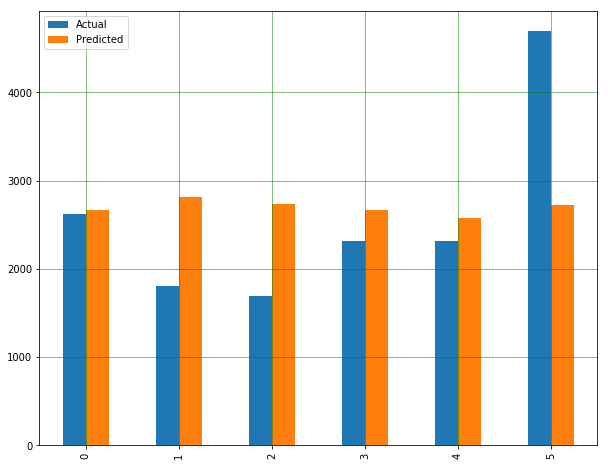

In [422]:
df.plot(kind='bar',figsize=(10,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [423]:
clf.coef_

array([-1.34435153, -0.59237392,  0.76178993,  1.28474146, -2.17882596,
        1.58303233,  0.9301572 ,  0.13060955, -1.89216783, -1.55025875,
        3.06280931,  0.87644388, -1.15377602, -2.88146054,  2.93750213])

In [424]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 782.0586728066788
Mean Squared Error: 1032680.9744664733
Root Mean Squared Error: 1016.2091194564598


In [425]:
gamma

array([6.50808256e-04, 7.34862023e-04, 9.00497611e-05, 6.66678072e-04,
       3.28562106e-04, 1.44071665e-04, 7.58804497e-04, 7.35693720e-04,
       6.34096065e-04, 2.58087169e-04, 7.60183080e-04, 3.79332421e-04,
       3.90030171e-04, 2.84424434e-04, 3.05121479e-04])

## Quadratic Regularization

In [426]:
nb_features = X.shape[1]

To do:
- Create matrix M
- Create matrix X (DONE)
- Compute X^TX
- Compute M^TM
- Verify M^TM value, if it coincides with the one G.O. wrote in report
- install library, define instances, run optimizer

In [427]:
def create_M(N):
    M = np.zeros((N,N))
    for i in range(15):
        for j in range(15):
            if i==0:
                if j == 0:
                    M[i,j]=1
                else:
                    M[i,j]=0
            elif (i==j):
                M[i,j]=1
            elif (j == (i-1)):
                M[i,j] = -1
            else:
                M[i,j]=0
    return M

In [441]:
pct_90 = int(np.ceil(90*len(X)/100))
pct_80 = int(np.ceil(80*len(X)/100))

#predict las 10%

X_train, X_test = X[:pct_80], X[pct_80:]
y_train, y_test =y[:pct_80], y[pct_80:]


In [609]:
import cvxopt

def generate_G(index):
    """index: represents k^*, gamma_{k^*} is such that gamma_0 <= gamma_1 <= ...<= gamma_{k^*} >= ... >= gamma_N
    """ 
    #this constraint verifies the gaussian-like distribution of the gamma
    G = np.zeros((N,N))
    for i in range(0, index):
        for j in range(N):
            if (i==j):
                G[i,j] = 1
            elif (j == i+1):
                G[i,j] = -1
                
    for i in range(index, N):
        for j in range(N):
            if (i==j):
                G[i,j] = -1
            elif (j == i+1):
                G[i,j] = 1

    
    #this constraint verifies that -gamma_i <= 0 <=> gamma_i >= 0 forall i
   # for i in range(N, 2*N):
    #    for j in range(N):
     #       if (i==N+j):
      #          G[i,j]=-1
    return G

def generate_params(X_train, y_train,k):
    M = create_M(15)
    M_tilde = M.T @ M
    X_tilde = X_train.T @ X_train
    P = X_tilde + 0.1*(M_tilde)
    q = -X_train.T@y_train
    G = generate_G(k)
    h = np.zeros((15,1))
    return P, q, G, h

def find_best_k():
    """Returns index of maximum gamma that minimizes the mae loss"""
    mae = {}
    for k in range(15):
        P, q, G, h = generate_params(X_train, y_train, k)
        gammas = cvxopt_solve_qp(P,q, G, h)
        y_pred = X_test@gammas
        mae[k] = metrics.mean_absolute_error(y_test, y_pred)
       
    return min(mae, key=mae.get)


def cvxopt_solve_qp(P, q, G=None, h=None, A=None, b=None):
    P = .5 * (P + P.T)  # make sure P is symmetric
    args = [cvxopt.matrix(P), cvxopt.matrix(q)]
    if G is not None:
        args.extend([cvxopt.matrix(G), cvxopt.matrix(h)])
        if A is not None:
            args.extend([cvxopt.matrix(A), cvxopt.matrix(b)])
    sol = cvxopt.solvers.qp(*args)
    if 'optimal' not in sol['status']:
        return None
    return np.array(sol['x']).reshape((P.shape[1],))

# Generate our prediction
index = find_best_k()
P, q, G, h = generate_params(X_train, y_train, index)
gamma = cvxopt_solve_qp(P, q, G, h)
y_pred = X_test@gamma


     pcost       dcost       gap    pres   dres
 0: -3.1781e+07 -3.1781e+07  3e+01  6e+00  2e-10
 1: -3.1781e+07 -3.1781e+07  9e+00  2e+00  6e-11
 2: -3.1781e+07 -3.1781e+07  9e+00  2e+00  6e-11
 3: -3.1736e+07 -3.1621e+07  9e+04  2e+00  6e-11
 4: -3.1722e+07 -3.1598e+07  9e+04  1e+00  5e-11
 5: -3.1227e+07 -3.1294e+07  9e+05  1e+00  4e-11
 6: -3.1095e+07 -3.1190e+07  2e+06  1e+00  4e-11
 7: -3.1155e+07 -3.1017e+07  2e+06  1e+00  4e-11
 8: -3.0432e+07 -3.0497e+07  2e+06  4e-01  1e-11
 9: -3.0629e+07 -3.0385e+07  6e+05  1e-01  5e-12
10: -3.0476e+07 -3.0288e+07  1e+05  4e-02  1e-12
11: -3.0328e+07 -3.0222e+07  8e+04  2e-02  6e-13
12: -3.0291e+07 -3.0205e+07  6e+04  1e-02  4e-13
13: -3.0266e+07 -3.0101e+07  6e+04  8e-03  3e-13
14: -3.0044e+07 -2.9968e+07  5e+04  2e-03  6e-14
15: -3.0006e+07 -2.9964e+07  3e+04  9e-04  3e-14
16: -3.0009e+07 -2.9953e+07  3e+04  9e-04  3e-14
17: -2.9992e+07 -2.9896e+07  1e+04  5e-04  2e-14
18: -2.9582e+07 -2.9756e+07  2e+05  3e-18  3e-15
19: -2.9729e+07 -2.97

In [610]:
gamma

array([ 5.38465439e-03,  5.38465403e-03,  5.38465367e-03,  5.38465334e-03,
       -3.07145201e-09, -2.90015230e-09, -2.63269302e-09, -2.30259013e-09,
       -1.96449956e-09, -1.62649073e-09, -1.27941278e-09, -9.30511966e-10,
       -5.79164618e-10, -2.18201860e-10,  1.31459826e-10])

In [544]:
dataframe_new

,Recovered Daily,Infected cases t-7,Infected cases t-8,Infected cases t-9,Infected cases t-10,Infected cases t-11,Infected cases t-12,Infected cases t-13,Infected cases t-14,Infected cases t-15,Infected cases t-16,Infected cases t-17,Infected cases t-18,Infected cases t-19,Infected cases t-20,Infected cases t-21
Date,,,,,,,,,,,,,,,,
2020-02-27,42,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,2.0
2020-02-28,1,19.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0
2020-02-29,0,59.0,19.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0
2020-03-01,37,150.0,59.0,19.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0
2020-03-02,66,221.0,150.0,59.0,19.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0
2020-03-03,11,311.0,221.0,150.0,59.0,19.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0
2020-03-04,116,438.0,311.0,221.0,150.0,59.0,19.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0
2020-03-05,138,593.0,438.0,311.0,221.0,150.0,59.0,19.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0
2020-03-06,109,821.0,593.0,438.0,311.0,221.0,150.0,59.0,19.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0


In [611]:
y_pred

array([2141.32450724, 2177.6116566 , 2210.01647226, 2237.74202436,
       2261.18677711, 2279.20380026, 2297.94237043, 2313.22937897,
       2322.0063416 , 2326.02865734, 2325.64094374, 2318.05395044])

In [612]:
df = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})
df


,Actual,Predicted
0,2128,2141.324507
1,1822,2177.611657
2,2723,2210.016472
3,2943,2237.742024
4,3033,2261.186777
5,2922,2279.203800
6,2622,2297.942370
7,1808,2313.229379
8,1696,2322.006342
9,2317,2326.028657


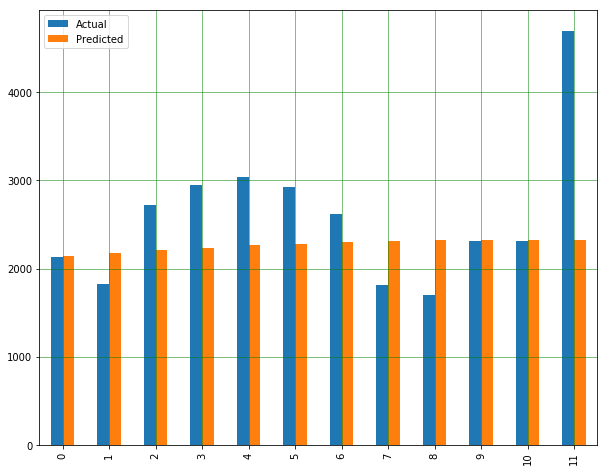

In [613]:
df.plot(kind='bar',figsize=(10,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [614]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 571.308007551839
Mean Squared Error: 690739.9445607568
Root Mean Squared Error: 831.1076612333427


In [493]:
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold

def cross_validation(X, y):
    y_tests = []
    y_preds = []
    kf = KFold(n_splits=10) # Define the split - into 2 folds 
    kf.get_n_splits(X)
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        
        P, q, G, h = generate_params(X_train, y_train)
        gammas = cvxopt_solve_qp(P, q, G, h)
        y_pred = X_test@gammas
        y_preds.append(y_pred)
        y_tests.append(y_test)
        
        return y_tests, y_preds

In [495]:
y_tests, y_preds = cross_validation(X, y)

     pcost       dcost       gap    pres   dres
 0: -7.2009e+07 -7.2009e+07  3e+01  5e+00  2e-10
 1: -7.2009e+07 -7.2009e+07  7e+00  2e+00  7e-11
 2: -7.2009e+07 -7.2009e+07  7e+00  2e+00  7e-11
 3: -6.9354e+07 -7.1844e+07  5e+06  2e+00  7e-11
 4: -7.0322e+07 -7.1348e+07  3e+06  7e-01  3e-11
 5: -7.0795e+07 -7.0945e+07  1e+06  3e-01  1e-11
 6: -7.0807e+07 -7.0664e+07  1e+06  2e-01  9e-12
 7: -7.0581e+07 -7.0189e+07  8e+05  1e-01  5e-12
 8: -7.0397e+07 -6.9996e+07  6e+05  6e-02  3e-12
 9: -7.0036e+07 -6.9633e+07  3e+05  2e-02  1e-12
10: -6.9843e+07 -6.9580e+07  2e+05  1e-02  6e-13
11: -6.9521e+07 -6.9524e+07  8e+04  1e-03  6e-14
12: -6.9514e+07 -6.9528e+07  3e+04  4e-04  2e-14
13: -6.9518e+07 -6.9518e+07  1e+03  1e-05  5e-16
14: -6.9518e+07 -6.9518e+07  1e+01  1e-07  1e-16
Optimal solution found.


In [615]:
coeff_df = pd.DataFrame(gamma, dataframe.iloc[:,1:].columns, columns=['Coefficient'])  
coeff_df

,Coefficient
Infected cases t-7,5.384654e-03
Infected cases t-8,5.384654e-03
Infected cases t-9,5.384654e-03
Infected cases t-10,5.384653e-03
Infected cases t-11,-3.071452e-09
Infected cases t-12,-2.900152e-09
Infected cases t-13,-2.632693e-09
Infected cases t-14,-2.302590e-09
Infected cases t-15,-1.964500e-09
Infected cases t-16,-1.626491e-09
